In [2]:
import random
random.seed(10242133)
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython import display
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import torch
from torch import nn
import torch.nn.functional as nnf

In [3]:
# data preprocessing (without standardization)
df = pd.read_csv('musicData.csv')
df.dropna(inplace=True) # five rows are dropped
df.drop(["instance_id", "artist_name", "track_name"], axis=1, inplace=True)
# popularity looks great
# acousticness looks great
# danceability looks great
# duration_ms looks great
# energy looks great
# instrumentalness looks great
# key -> string to numerical
df["key"].replace({"A": 1, "A#": 2, "B": 3, "C": 4, "C#": 5, "D": 6, "D#": 7, "E": 8, "F": 9, "F#": 10, "G": 11, "G#": 12}, inplace=True)
# liveness looks great
# loudness looks great
# mode -> dummy coded
df = pd.get_dummies(df, columns = ['mode'])
# speechiness looks great
# tempo -> replace '?' with NaN and change the data type
df["tempo"].replace("?", np.NaN, inplace=True)
df["tempo"] = df["tempo"].astype("float")
# obtained date -> replace a bizarre value '0/4' with the most common obtained date value
# obtained data -> change to dummy variables
df['obtained_date'].replace({'0/4': df['obtained_date'].value_counts().index[0]}, inplace=True)
df = pd.get_dummies(df, columns = ['obtained_date'])
# music genre -> change to model-friendly catagorical variables
df['music_genre'] = OrdinalEncoder().fit_transform(df[['music_genre']])


In [4]:
# train, test split
genres = list(df["music_genre"].unique())
train_set = pd.DataFrame(columns=df.columns)
test_set = pd.DataFrame(columns=df.columns)
for genre in genres:
    df_this_genre = df[df["music_genre"]==genre]
    train_this_genre, test_this_genre = train_test_split(df_this_genre, test_size=0.1)
    train_set = pd.concat([train_set, train_this_genre], axis=0)
    test_set = pd.concat([test_set, test_this_genre], axis=0)
X_train = train_set.drop("music_genre", axis=1, inplace=False)
X_test = test_set.drop("music_genre", axis=1, inplace=False)
y_train = train_set["music_genre"].astype('int')
y_test = test_set["music_genre"].astype('int')

In [5]:
# deal with empty values in tempo and do standardization
X_train["tempo"].fillna(X_train["tempo"].mean(), inplace=True)
X_test["tempo"].fillna(X_test["tempo"].mean(), inplace=True)
X_train[["acousticness"]] = MinMaxScaler().fit_transform(X_train[["acousticness"]])
X_test[["acousticness"]] = MinMaxScaler().fit_transform(X_test[["acousticness"]])
col_names = ['popularity', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'speechiness',
       'tempo', 'valence']
X_train[col_names] = StandardScaler().fit_transform(X_train[col_names].values)
X_test[col_names] = StandardScaler().fit_transform(X_test[col_names].values)

In [6]:
# dimensionality reduction using PCA
pca = PCA(.95)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

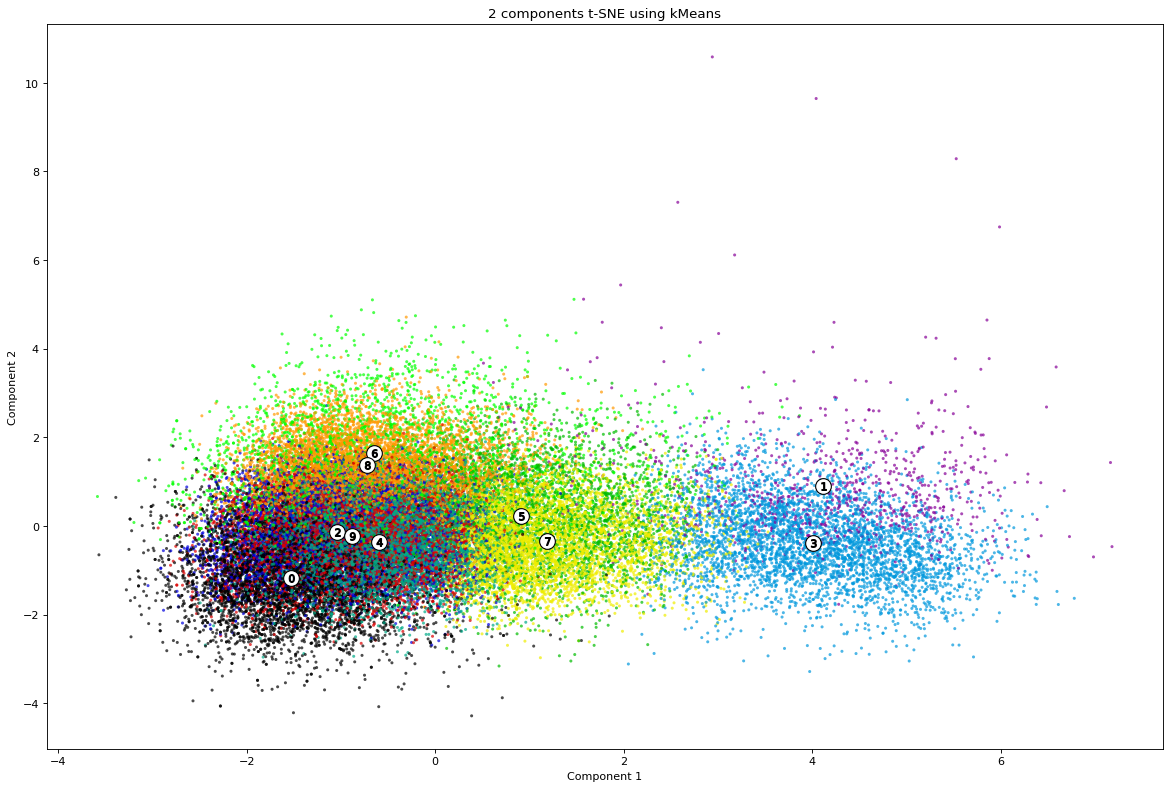

In [7]:
# visualization
clusterer = KMeans(n_clusters=10)
clusterer_labels = clusterer.fit_predict(X_train_pca)
centers = clusterer.cluster_centers_
colors = cm.nipy_spectral(clusterer_labels.astype(float) / 10)
plt.figure(figsize=(18, 12), dpi=80)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
plt.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200,edgecolor="k")
for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
plt.title('2 components t-SNE using kMeans' )
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [395]:
# clustering
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)
clustering = KMeans(n_clusters=10)
clustering.fit(X_train_pca)
train_labels = clustering.labels_
X_train_clstrs = X_train_pca.copy()
X_train_clstrs['clusters'] = train_labels
test_labels = clustering.predict(X_test_pca)
X_test_clstrs = X_test_pca.copy()
X_test_clstrs['clusters'] = test_labels
X_test_clstrs = pd.get_dummies(X_test_clstrs, columns = ['clusters'])
X_train_clstrs = pd.get_dummies(X_train_clstrs, columns = ['clusters'])

AUC of Multi-Class Support Vector Machine is: 0.9217242222222225


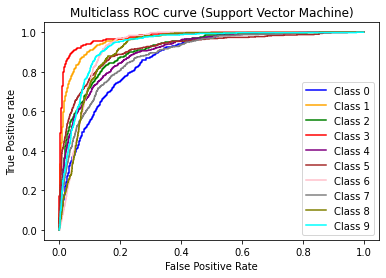

In [396]:
# Classification using SVM
sv = SVC(probability=True).fit(X_train_clstrs, y_train)
y_prob_pred_svm = sv.predict_proba(X_test_clstrs)
fpr = dict()
tpr = dict()
threshold ={}
color = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i in range(10):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test, y_prob_pred_svm[:,i], pos_label=i)
    plt.plot(fpr[i], tpr[i] ,color=color[i], label='Class {}'.format(i))
plt.title('Multiclass ROC curve (Support Vector Machine)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
print("AUC of Multi-Class Support Vector Machine is:", roc_auc_score(y_test, y_prob_pred_svm, multi_class='ovo', average='weighted'))


AUC of Single Decision Tree is: 0.8343810000000004


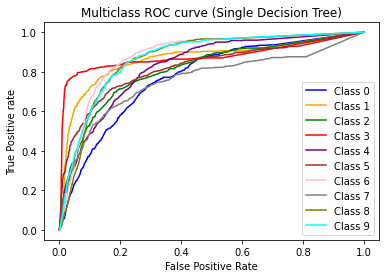

In [404]:
# Classification using Single Decision Tree
sdt = DecisionTreeClassifier(max_depth = 12, criterion='gini').fit(X_train_clstrs, y_train)
y_pred_proba_sdt = sdt.predict_proba(X_test_clstrs)
fpr = dict()
tpr = dict()
threshold ={}
color = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i in range(10):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test, y_pred_proba_sdt[:,i], pos_label=i)
    plt.plot(fpr[i], tpr[i] ,color=color[i], label='Class {}'.format(i))
plt.title('Multiclass ROC curve (Single Decision Tree)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
print("AUC of Single Decision Tree is:", roc_auc_score(y_test, y_pred_proba_sdt, multi_class='ovo', average='weighted'))


AUC of Random Forest is: 0.900935866666667


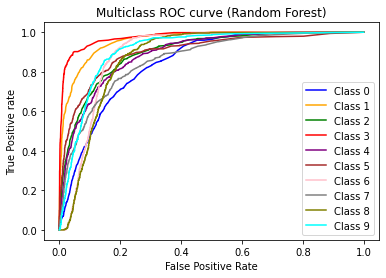

In [398]:
# Classification using Random Forest
rf = RandomForestClassifier(n_estimators = 200, max_samples = 1.0, max_features = 0.2, bootstrap = True, criterion='gini').fit(X_train_clstrs, y_train)
y_pred_proba_rf = rf.predict_proba(X_test_clstrs)
fpr = dict()
tpr = dict()
threshold ={}
color = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i in range(10):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test, y_pred_proba_rf[:,i], pos_label=i)
    plt.plot(fpr[i], tpr[i] ,color=color[i], label='Class {}'.format(i))
plt.title('Multiclass ROC curve (Random Forest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
print("AUC of Random Forest is:", roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovo', average='weighted'))


AUC of AdaBoost is: 0.8508239555555561


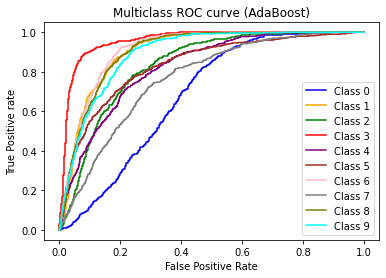

In [399]:
# Classification using AdaBoost
ab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=2000, learning_rate=1).fit(X_train_clstrs, y_train)
y_pred_proba_ab = ab.predict_proba(X_test_clstrs)
fpr = dict()
tpr = dict()
threshold ={}
color = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i in range(10):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test, y_pred_proba_ab[:,i], pos_label=i)
    plt.plot(fpr[i], tpr[i] ,color=color[i], label='Class {}'.format(i))
plt.title('Multiclass ROC curve (AdaBoost)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
print("AUC of AdaBoost is:", roc_auc_score(y_test, y_pred_proba_ab, multi_class='ovo', average='weighted'))


AUC of Neural Network is: 0.9255717111111116


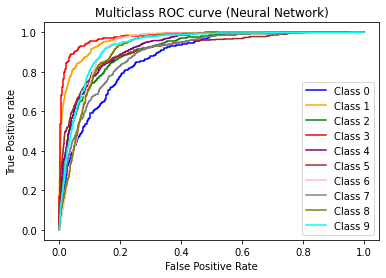

In [400]:
# Classification using Neural Network
learning_rate = 3
lambda_l2 = 1e-5
D = 21
C = 10
H = 40
X_train_clstrs_tensor = torch.tensor(X_train_clstrs.astype(np.float32).values)
X_test_clstrs_tensor = torch.tensor(X_test_clstrs.astype(np.float32).values)
y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)
model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C),
)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)
for t in range(2000):
    y_pred = model(X_train_clstrs_tensor)
    loss = criterion(y_pred, y_train_tensor)
    score, predicted = torch.max(y_pred, 1)
    acc = (y_train_tensor == predicted).sum().float() / len(y_train_tensor)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
y_pred_nn = model(X_test_clstrs_tensor)
y_pred_proba_nn = nnf.softmax(y_pred_nn,dim=1)
fpr = dict()
tpr = dict()
threshold ={}
color = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i in range(10):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test, y_pred_proba_nn.detach().numpy()[:,i], pos_label=i)
    plt.plot(fpr[i], tpr[i] ,color=color[i], label='Class {}'.format(i))
plt.title('Multiclass ROC curve (Neural Network)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
print("AUC of Neural Network is:", roc_auc_score(y_test, y_pred_proba_nn.detach().numpy(), multi_class='ovo', average='weighted'))
